In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
font = {
        'size'   : 12}

mpl.rc('font', **font)

In [2]:
years = [1991, 2020]
clim_years = [1991, 2020]
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
f_ice=basepath+f'/OISST/oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
with xr.open_dataset(f_ice) as fice:
    icemask1=np.nanmax(fice.ice.data,axis=0)>0
    Amax=np.zeros((20,)+np.shape(icemask1))
    for ind in range(0,20):
        Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)
    AmaxH=np.mean(np.where(Amax>0,1,0),axis=0)
    icemask=AmaxH>0.5
    latice=fice.lat.values
    lonice=fice.lon.values

/tmp/reo000/546857/ipykernel_650968/1747760165.py:6: RuntimeWarning: All-NaN slice encountered
  icemask1=np.nanmax(fice.ice.data,axis=0)>0
/tmp/reo000/546857/ipykernel_650968/1747760165.py:9: RuntimeWarning: All-NaN slice encountered
  Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)


In [3]:
def SEDIpath(mods,is_detrend,years,il):
    # Input/output directory
    mhwdir = '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW/mhw/detrended' if is_detrend else None
    if is_detrend:
        f_save = f'{mhwdir}/SEDI_MME_{"_".join(mods)}_l{il}_detrended_{years[0]}_{years[1]}.nc'
    else:
        f_save = f'{mhwdir}/SEDI_MME_{"_".join(mods)}_l{il}_{years[0]}_{years[1]}.nc'
    return f_save
fname=SEDIpath(['GEM5.2-NEMO',],is_detrend=True,years=clim_years,il=1)
ff1=xr.open_dataset(fname)
lm=np.isnan(ff1.SEDI.values)

In [4]:
fullmask=np.tile(np.logical_or(lm,icemask),(360,1,1))

In [5]:
f_obs = '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.1991_2020.nc'
fobs=xr.open_dataset(f_obs)
omhw=fobs['is_mhw'].data

In [6]:
def getcounts(il):
    patha=f'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW/mhw/detrended/mhw_GEM5.2-NEMO_l{il}_detrended_1991_2020.nc'
    pathb=f'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW/mhw/detrended/mhw_CanESM5_l{il}_detrended_1991_2020.nc'
    ffa=xr.open_dataset(patha)
    ffb=xr.open_dataset(pathb)
    MHW_all=np.concatenate((ffa['is_mhw'].data,ffb['is_mhw'].data),axis=1)
    MHW_prob=np.ma.masked_where(fullmask==1,np.sum(MHW_all,axis=1))
    mcount=[]
    ocount=[]
    ips=np.arange(0,41)
    for ip in ips:
        ind=MHW_prob==ip
        msum=np.sum(ind)
        osum=np.sum(omhw[ind])
        mcount.append(msum)
        ocount.append(osum)
    mcount=np.array(mcount)
    ocount=np.array(ocount)
    return mcount, ocount

In [7]:
mcounts={}
ocounts={}
for il in (1,3,6,10):
    mcounts[il],ocounts[il]=getcounts(il)

In [8]:
ips=np.arange(0,41)
cols={1:'red',3:'darkorange',6:'darkcyan',10:'purple'}

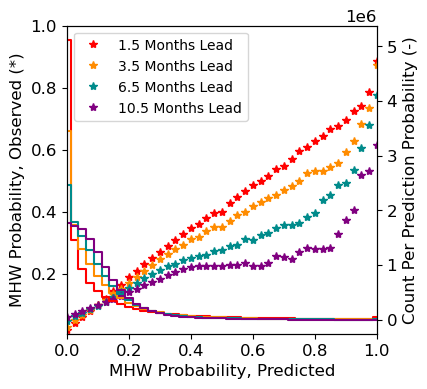

In [13]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
axb=ax.twinx()
for il in (1,3,6,10):
    ax.plot(ips/40,ocounts[il]/mcounts[il],'*',color=cols[il],label=f"{il+.5} Months Lead")
    ax.set_aspect(1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1.008)
    ax.set_xticks([0,.2,.4,.6,.8,1])
    ax.set_yticks([.2,.4,.6,.8,1.])
    axb.step(ips/40,mcounts[il],cols[il],where='mid')
    #axb.set_yscale('log')
ax.legend(fontsize=10)
ax.set_xlabel('MHW Probability, Predicted')
ax.set_ylabel('MHW Probability, Observed (*)')
axb.set_ylabel('Count Per Prediction Probability (-)')

fig.savefig('Rel2.png',dpi=600,bbox_inches='tight')